In [1]:
from backtesting.test import SMA

In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from  torch.functional import F
from backtesting.lib import SignalStrategy, TrailingStrategy

def EMA(df:pd.Series, n:int, fillna:bool=True) -> np.ndarray:
    """
    Exponential Moving Average
    return: np.ndarray
    """
    return ta.ema(pd.Series(df), length=n, fillna=fillna)

def Zscore(df:pd.Series, n:int, fillna:bool=True) -> np.ndarray:
    """
    Zscore
    return: np.ndarray
    """
    return ta.zscore(pd.Series(df), length=n, fillna=fillna)

def Fake_neural_network(df:pd.Series, generate_params:list, input_params:list, fillna:bool=True) -> np.ndarray:
    """
    Fake neural network
    generate_params: list => [n1, n2, n3, n4, n5, n6, n7, n8, n9, n10]
    input_params: list => [n1, n2, n3, n4, n5, n6, n7, n8, n9, n10]
    return: np.ndarray
    """
    """
    algorithm:
        1. df * gp -> (df,1) * (1,gp) -> (df, gp)
        2. (df, gp) * ip -> (df, gp) * (gp, ip) -> (df, ip)
        3. (df, ip) * 1 -> (df, ip) * (ip, 1) -> (df, 1)
        4. sigmod((df, 1)) -> (df, 1)
    """
    df = pd.Series(df)
    sigmod = lambda x: 1 / (1 + np.exp(-x))
    gp = np.array(generate_params).reshape(1, -1)
    print(gp.shape)
    ip = np.array(input_params).reshape(-1, 1)
    print(ip.shape)
    df = df.values.reshape(-1, 1)
    out = sigmod(np.matmul(np.matmul(df, gp), ip)).reshape(-1, 1)
    print(out[:10])
    #change to 1d array
    return out.reshape(-1)
    

class SmaCross(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        sma1 = self.I(SMA, self.data.Close, self.n1)
        sma2 = self.I(SMA, self.data.Close, self.n2)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = (pd.Series(sma1) > sma2).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)  # Upwards/long only

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(2)

class EmaCross_with_Zscore(SignalStrategy,
               TrailingStrategy):
    n1 = 10
    n2 = 25
    z_n = 10
    trailing_stop = 2
    
    def init(self):
        # In init() and in next() it is important to call the
        # super method to properly initialize the parent classes
        super().init()
        
        # Precompute the two moving averages
        ema1 = self.I(EMA, self.data.Close, self.n1)
        ema2 = self.I(EMA, self.data.Close, self.n2)
        zscore = self.I(Zscore, self.data.Close, self.z_n)
        
        # Where sma1 crosses sma2 upwards. Diff gives us [-1,0, *1*]
        signal = ((pd.Series(ema1) > ema2) & (pd.Series(zscore) > 0)).astype(int).diff().fillna(0)
        signal = signal.replace(-1, 0)

        # Use 95% of available liquidity (at the time) on each order.
        # (Leaving a value of 1. would instead buy a single share.)
        entry_size = signal * .95
                
        # Set order entry sizes using the method provided by 
        # `SignalStrategy`. See the docs.
        self.set_signal(entry_size=entry_size)
        
        # Set trailing stop-loss to 2x ATR using
        # the method provided by `TrailingStrategy`
        self.set_trailing_sl(self.trailing_stop)

In [3]:
data = pd.read_csv('./data/BTCUSDT_15m.csv', index_col='time', parse_dates=True)

In [4]:
#rename columns
data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)

In [5]:
data.head()

,Open,High,Low,Close,Volume
time,,,,,
2023-05-01 00:00:00,29223.0,29313.2,29198.2,29280.8,8574.387
2023-05-01 00:15:00,29280.7,29305.0,29252.1,29289.9,3585.558
2023-05-01 00:30:00,29290.0,29297.5,29268.2,29292.0,2365.554
2023-05-01 00:45:00,29292.0,29325.5,29271.3,29303.3,2200.431
2023-05-01 01:00:00,29303.3,29303.3,29226.0,29245.8,2160.645


In [6]:
data.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object

In [7]:
from backtesting import Backtest

bt = Backtest(data, EmaCross_with_Zscore,
              commission=.002,cash=100000)

bt.run()


Start                     2023-05-01 00:00:00
End                       2023-10-19 07:30:00
Duration                    171 days 07:30:00
Exposure Time [%]                   47.741229
Equity Final [$]                   54809.8878
Equity Peak [$]                   100043.8378
Return [%]                         -45.190112
Buy & Hold Return [%]               -3.339731
Return (Ann.) [%]                  -71.706729
Volatility (Ann.) [%]                5.098673
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -46.01698
Avg. Drawdown [%]                   -46.01698
Max. Drawdown Duration      171 days 02:30:00
Avg. Drawdown Duration      171 days 02:30:00
# Trades                                  444
Win Rate [%]                        22.747748
Best Trade [%]                       5.306969
Worst Trade [%]                     -1.416536
Avg. Trade [%]                    

In [8]:
%%time


UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [9]:
%%time
stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    z_n=range(5, 30, 5),
                    trailing_stop=np.arange(0.2, 2.2, 0.2).tolist(),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

C:\Users\hiban\AppData\Roaming\Python\Python310\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 2250 configurations.
  output = _optimize_grid()


  0%|          | 0/13 [00:00<?, ?it/s]

CPU times: total: 6min 19s
Wall time: 7min 10s


Start                     2023-05-01 00:00:00
End                       2023-10-19 07:30:00
Duration                    171 days 07:30:00
Exposure Time [%]                   30.504043
Equity Final [$]                   63731.5532
Equity Peak [$]                      100000.0
Return [%]                         -36.268447
Buy & Hold Return [%]               -3.339731
Return (Ann.) [%]                  -61.556577
Volatility (Ann.) [%]                7.159895
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -39.13557
Avg. Drawdown [%]                   -39.13557
Max. Drawdown Duration      169 days 19:00:00
Avg. Drawdown Duration      169 days 19:00:00
# Trades                                  341
Win Rate [%]                        21.994135
Best Trade [%]                       5.369013
Worst Trade [%]                     -1.264658
Avg. Trade [%]                    

In [10]:
stats['_equity_curve']

,Equity,DrawdownPct,DrawdownDuration
time,,,
2023-05-01 00:00:00,100000.0000,0.000000,NaT
2023-05-01 00:15:00,100000.0000,0.000000,NaT
2023-05-01 00:30:00,100000.0000,0.000000,NaT
2023-05-01 00:45:00,100000.0000,0.000000,NaT
2023-05-01 01:00:00,100000.0000,0.000000,NaT
...,...,...,...
2023-10-19 06:30:00,63828.9532,0.361710,NaT
2023-10-19 06:45:00,63792.3532,0.362076,NaT
2023-10-19 07:00:00,63740.3532,0.362596,NaT


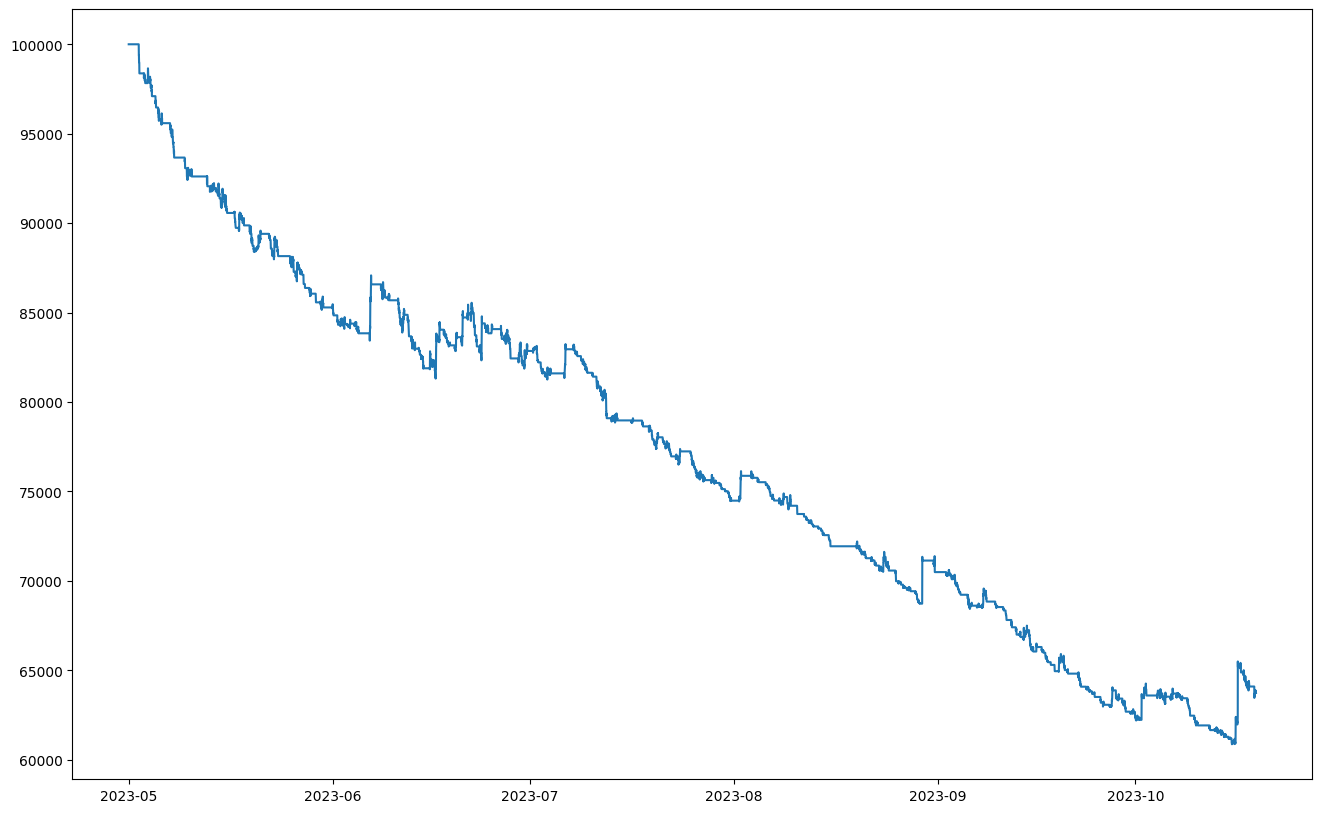

In [11]:
import matplotlib.pyplot as plt

#stats['_equity_curve']
plt.figure(figsize=(16, 10))
plt.plot(stats['_equity_curve']['Equity'])
plt.show()